# Analysis of Airbnb Seattle 

### Business Understanding (Problems Defined)
The one-year Seattle Airbnb home data is analyzed in this notebook.

The first dataset is the **calendar.csv**, which includes all the listing price of the airbnb housing from Jan1st 2016 to Jan 7th, 2017

The second dataset is the **listing.csv**, which includes the specifc infomation about the listing such as its neighbourhood, amenity, picture_url, host information, review score etc.

There are three questions I try to explore from these three datasets
-  What are the busiest times of the year to visit Seattle? By how much do prices spike?
-  Can we use other listing information to predict the housing price?
-  The vibe of each Seattle neighborhood using listing descriptions?

In [3]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns

#import dataset
df = pd.read_csv("~/AirbnbSeattle/calendar.csv") 
list_df = pd.read_csv("~/AirbnbSeattle/listings.csv")

/Users/rendongmin/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Question1: Seasonality of the price

In order to anaylize the trend of the housing price and identify when the busiest timing is, several steps are performed below:
-  Cleaning the data for aggregation and visualization
-  Visualize the time trend of the data
-  Calculate by how much the price spikes and if there's some outliers

In [4]:
#convert the data of time and price
#drop all of the na price, which is the unavailable housing
df['date'] = pd.to_datetime(df['date'])
df[['price']] = df[['price']].replace('[\$,]','',regex=True).astype(float)
df = df.dropna()

In [5]:
df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
9,241032,2016-01-13,t,85.0
10,241032,2016-01-14,t,85.0
14,241032,2016-01-18,t,85.0


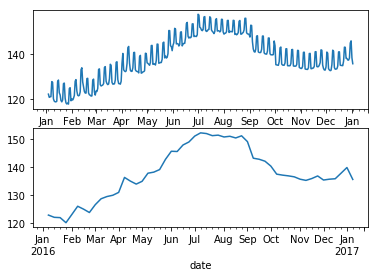

In [6]:
pricedf = df.groupby(['date'])['price'].mean()
plt.subplot(211)
pricedf.resample('D').mean().plot()
plt.subplot(212)
pricedf.resample('W').mean().plot()

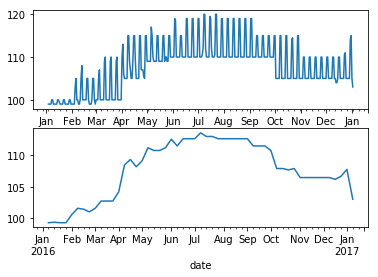

In [7]:
#Check robustness with median
pricedf = df.groupby(['date'])['price'].median()
plt.subplot(211)
pricedf.resample('D').mean().plot()
plt.subplot(212)
pricedf.resample('W').mean().plot()

#### **Conclusion**

As we could see from the line graph, it seems that the busiest season of Seattle in a year is around summer, the price keeps going from **January (117 average, 99 median)** and reached the peak on **July (157 average, 120 median)**. The average of the listing price increased by 25% compared the start of the year.

### Question2: Predicting the listing price

Secondly, we tried to identify if we could build one machine learning model to help us predict the listing price:
-  Cleaning both numerical and categorical variables
-  Perform PCA Analysis and Try different models
-  Tuning the parameter to select the best model

In [8]:
# Take a look at the dataset
list_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


**Numeric Data**
1. We drop out three unmeaningful data id, latitude, longitude 
2. We drop out license and square_feet since over 90% of the data is null
3. For the rest of the data, if there is null value, we fill them in with the man of the column

In [9]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numlist = list_df.select_dtypes(include=numerics)
numlist.isna().sum()/numlist.shape[0]
droplist = ['scrape_id','host_id','latitude','longitude','license','square_feet']
#square_feet have 97% of the null value in the data
numlist = numlist.drop(droplist,axis=1)
numlist2 = numlist.fillna(numlist.mean())

In [10]:
numlist2.head()
numlist2.describe()

,id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,...,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000
mean,5.550111e+06,7.157757,7.157757,3.349398,1.259469,1.307712,1.735394,1.672603,2.369303,780.447617,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,2.962660e+06,28.620648,28.620648,1.977599,0.589130,0.882700,1.139330,1.311040,16.305902,1683.589007,...,37.730892,6.020223,0.635022,0.725880,0.541745,0.517493,0.572542,0.682751,5.893029,1.665964
min,3.335000e+03,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,3.258256e+06,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,...,2.000000,94.000000,9.636392,9.000000,9.786709,9.809599,9.000000,9.000000,1.000000,0.830000
50%,6.118244e+06,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1125.000000,...,9.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.452245,1.000000,2.000000
75%,8.035127e+06,3.000000,3.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1125.000000,...,26.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.660000
max,1.034016e+07,502.000000,502.000000,16.000000,8.000000,7.000000,15.000000,15.000000,1000.000000,100000.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


**Categorical Data**
1. For the convenient of on-hot coding, I drop out some of the vairables. They are irrelevent, not useful or takes long time to transform and group them into useful feature
2. Some of the variables such as rate or price are supposed to be numeric but are stored as categorical. Convert them into numeric type.
3. For some of the na value, replace them with the mode of the columns
4. Finally, do one-hot encoding on all the selected categorical data, spreading them into seperate columns

In [11]:
category = ['object']
catlist = list_df.select_dtypes(include=category)

In [12]:
catlist2 = catlist.iloc[:,19:]
#square_feet have 97% of the null value in the data
catlist2 = catlist2.drop(catlist2.columns[catlist2.apply(lambda col: col.isnull().mean() > 0.4)], axis=1)
droplist = ['host_thumbnail_url','host_picture_url','city','state','country_code','country','calendar_last_scraped',
            'first_review','last_review','jurisdiction_names','host_verifications','street','neighbourhood',
           'neighbourhood_cleansed','market','zipcode','smart_location','calendar_updated','amenities','host_neighbourhood',
           'cleaning_fee','extra_people']
#no idea how to deal with amenities
catlist3 = catlist2.drop(droplist,axis=1)

In [13]:
catlist3['host_response_rate'] = catlist3['host_response_rate'].str.rstrip('%').astype('float') / 100.0
catlist3['host_response_rate'] = catlist3['host_response_rate'].fillna(catlist3['host_response_rate'].mean())
catlist3['host_acceptance_rate'] = catlist3['host_acceptance_rate'].str.rstrip('%').astype('float') / 100.0
catlist3['host_acceptance_rate'] = catlist3['host_acceptance_rate'].fillna(catlist3['host_acceptance_rate'].mean())
catlist3[['price']] = catlist3[['price']].replace('[\$,]','',regex=True).astype(float)

In [14]:
catlist3.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,is_location_exact,property_type,room_type,bed_type,price,has_availability,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,within a few hours,0.960000,1.000000,f,t,t,Queen Anne,t,Apartment,Entire home/apt,Real Bed,85.0,t,f,f,moderate,f,f
1,within an hour,0.980000,1.000000,t,t,t,Queen Anne,t,Apartment,Entire home/apt,Real Bed,150.0,t,f,f,strict,t,t
2,within a few hours,0.670000,1.000000,f,t,t,Queen Anne,t,House,Entire home/apt,Real Bed,975.0,t,f,f,strict,f,f
3,NaN,0.948868,0.999672,f,t,t,Queen Anne,t,Apartment,Entire home/apt,Real Bed,100.0,t,f,f,flexible,f,f
4,within an hour,1.000000,0.999672,f,t,t,Queen Anne,t,House,Entire home/apt,Real Bed,450.0,t,f,f,strict,f,f


In [15]:
listdata = pd.concat([numlist2, catlist3], axis=1,sort=False)

In [16]:
category = ['object']
catlist = listdata.select_dtypes(include=category)
numlist3 = listdata.select_dtypes(include=numerics)
catlist4 = catlist.apply(lambda col: col.fillna(col.mode()[0]),axis=1)
listdata2 = pd.concat([numlist3, catlist4], axis=1,sort=False)
listdata3 = pd.get_dummies(listdata2)

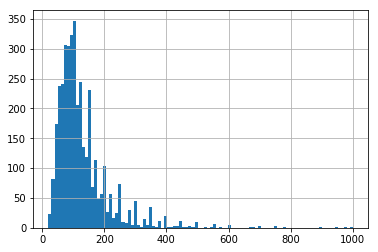

In [17]:
#take a look at the price distribution
listdata3['price'].hist(bins=100)

In [18]:
listdata3.head()

,id,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,...,requires_license_f,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,241032,3.0,3.0,4,1.0,1.0,1.0,2,1,365,...,1,1,0,0,1,0,1,0,1,0
1,953595,6.0,6.0,4,1.0,1.0,1.0,1,2,90,...,1,1,0,0,0,1,0,1,0,1
2,3308979,2.0,2.0,11,4.5,5.0,7.0,10,4,30,...,1,1,0,0,0,1,1,0,1,0
3,7421966,1.0,1.0,3,1.0,0.0,2.0,1,1,1125,...,1,1,0,1,0,0,1,0,1,0
4,278830,2.0,2.0,6,2.0,3.0,3.0,6,1,1125,...,1,1,0,0,0,1,1,0,1,0


In [19]:
X = listdata3.drop(columns=['price','id'])
y = listdata3['price']
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)

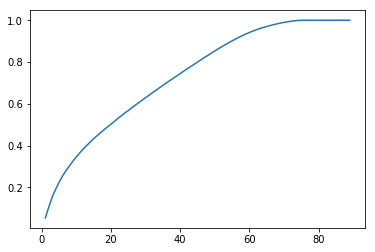

In [20]:
from sklearn.decomposition import PCA
explained_var = list()
for i in range(1,90):
    pca = PCA(n_components=i)
    pca.fit(rescaledX)
    explained_var.append(pca.explained_variance_ratio_.sum())
x = np.arange(1, 90)
expained_var = np.array(explained_var)
plt.plot(x,explained_var)

In [21]:
pca = PCA(n_components=42) 
pca.fit(rescaledX)
pcadata = pca.fit_transform(rescaledX)
pca.explained_variance_ratio_.sum()

0.767097663770291

In [22]:
X_train, X_test, y_train, y_test = train_test_split(pcadata, y, test_size=0.25, random_state=42)
lnmodel = LinearRegression(normalize=True)
lnmodel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [23]:
y_test_pred = lnmodel.predict(X_test)
y_train_pred = lnmodel.predict(X_train)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 3552.869, test: 3554.122
R^2 train: 0.560, test: 0.575


In [24]:
#Write a function to report performance of the model
def model_perf(Xdata,component_low,component_high,model):
    mse_train = list()
    mse_test = list()
    r2_train = list()
    r2_test = list()
    for i in range(component_low,component_high):
        pca = PCA(n_components=i) 
        pca.fit(Xdata)
        pcadata = pca.fit_transform(Xdata)
        X_train, X_test, y_train, y_test = train_test_split(pcadata, y, test_size=0.25, random_state=42)
        model.fit(X_train,y_train)
        y_test_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        mse_train.append(mean_squared_error(y_train, y_train_pred))
        mse_test.append(mean_squared_error(y_test, y_test_pred))
        r2_train.append(r2_score(y_train, y_train_pred))
        r2_test.append(r2_score(y_test, y_test_pred))
    x = range(component_low,component_high)
    plt.plot(x,mse_train,color='black')
    plt.plot(x,mse_test,color='blue')
    plt.show()

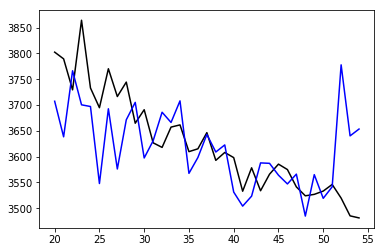

In [25]:
lnmodel = LinearRegression(normalize=True)
model_perf(rescaledX,20,55,lnmodel)

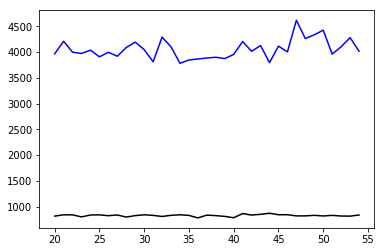

In [26]:
# It seems that random forest would greatly overfit the data in this case
forest = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=10, criterion='mse')
model_perf(rescaledX,20,55,forest)

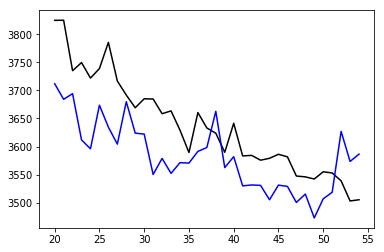

In [28]:
lassomodel = linear_model.Lasso(alpha=0.8)
model_perf(rescaledX,20,55,lassomodel)

In [29]:
# Fianl
pca = PCA(n_components=46) 
pca.fit(rescaledX)
pcadata = pca.fit_transform(rescaledX)
pca.explained_variance_ratio_.sum()
lassomodel = linear_model.Lasso(alpha=0.8)
lassomodel.fit(X_train, y_train)
y_train_pred = lassomodel.predict(X_train)
y_test_pred = lassomodel.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 3572.339, test: 3507.392
R^2 train: 0.557, test: 0.580


#### Conclusion
After we composed PCA analysis and tried different number of components on different models including linear regression, random forest and lasso regression, we found that by evluating using mse score, **lasso-regression performs the best out of the three models and the result is more consistent**.

And we further tuning this parameter, and set the alpha to be at 0.8, the final model reports that the mse on test set is 3580, and R-square is 0.571. 

The model can be further improved by included some of the variables that I exclude in the analysis (I still need to learn how to process these data) or combine and contruct some of the new and more meaningful feature.

### Question3: Neighbourhood Vibe

Finally, we use the neighbourhood overview data to try get a taste of the vibe in each neighbourhood. Following steps are executed:
-  Select top5 neighbourhood with most count of text for analysis
-  Calculate the tf_idf and get the top5 words for each target neighbourhood
-  Interpreting the result of the analysis

In [30]:
n = ['neighbourhood','neighborhood_overview']
neighbour = list_df[n]

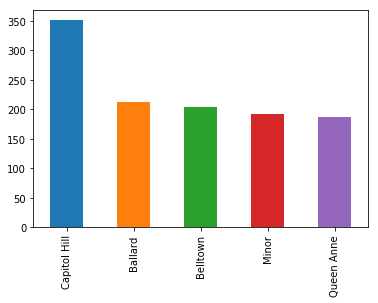

In [31]:
neighbour['neighbourhood'].value_counts().nlargest(5).plot.bar()

In [32]:
# We select the following 5 neighbourhood as target community for further analysis
subset = ['Capitol Hill','Ballard','Belltown','Minor','Queen Anne']
neighbour = neighbour[neighbour.neighbourhood.isin(subset)]
neighbour['words'] = neighbour.neighborhood_overview.str.strip().str.split('[\W_]+')
neighbour.head()
n2 = neighbour.dropna(subset= ['words'])

In [33]:
rows = list()
for row in n2[['neighbourhood', 'words']].iterrows():
    r = row[1]
    for word in r.words:
        rows.append((r.neighbourhood, word))

words = pd.DataFrame(rows, columns=['neighbourhood', 'word'])
words = words[words.word.str.len() > 0]
words['word'] = words.word.str.lower()
words.head()

,neighbourhood,word
0,Queen Anne,queen
1,Queen Anne,anne
2,Queen Anne,is
3,Queen Anne,a
4,Queen Anne,wonderful


In [34]:
counts = words.groupby('neighbourhood').word.value_counts().to_frame().rename(columns={'word':'n_w'})
counts.head()

n_w
neighbourhood word     
Ballard       the   621
              and   531
              a     376
              to    335
              of    312

In [35]:
#define a function to plot top_n result of each group
def pretty_plot_top_n(series, top_n=5, index_level=0):
    r = series\
    .groupby(level=index_level)\
    .nlargest(top_n)\
    .reset_index(level=index_level, drop=True)
    r.plot.bar()
    return r.to_frame()

tf_idf
neighbourhood word                  
Ballard       fishing       0.001567
              scandinavian  0.001567
              phinney       0.001436
              delancey      0.001306
              chittenden    0.001175
Belltown      adults        0.004459
              clipper       0.001427
              words         0.001427
              caffeinated   0.001248
              energized     0.001248
Capitol Hill  volunteer     0.002391
              admired       0.001741
              zipcar        0.001415
              fifteen       0.001197
              anderson      0.001172
Minor         valley        0.005913
              madison       0.003908
              gems          0.002750
              ethiopian     0.002338
              madrona       0.001925
Queen Anne    kerry         0.002693
              upper         0.001675
              crown         0.001346
              hilltop       0.001197
              canlis        0.001047

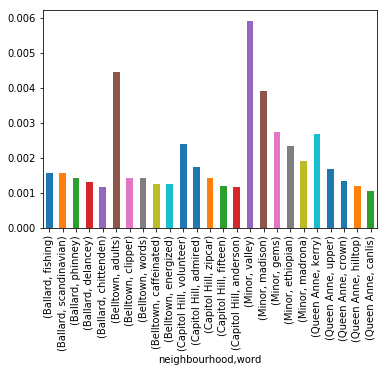

In [36]:
word_sum = counts.groupby(level=0).sum().rename(columns={'n_w': 'n_d'})
tf = counts.join(word_sum)
tf['tf'] = tf.n_w/tf.n_d
c_d = words.neighbourhood.nunique()
idf = words.groupby('word').neighbourhood.nunique().to_frame().rename(columns={'neighbourhood':'i_d'}).sort_values('i_d')
idf['idf'] = np.log(c_d/idf.i_d.values)
tf_idf = tf.join(idf)
tf_idf['tf_idf'] = tf_idf.tf * tf_idf.idf
pretty_plot_top_n(tf_idf['tf_idf'])

#### Conclusion

By looking at the tf_dif, we could have general taste about the vibe of each neighborhood. And we could double check our result with wikipedia
-  **Ballard: fishing, scandinavian, phinney, delancey, chittenden** : Ballard is place great for fishing. You could appreaciate the scandinavian culture. Phinney seems to a famous spot there

-  **Belltown: Adults, clipper, words, caffeinated, energized** : Belltown seems to be great place for adult to hangout, caffeinated probably indicates that there're lots of coffee/ chocolate shop nearby.

-  **Capital Hill: volunteer, admire, zipcar, fifteen, anderson**: For capital hill, there're are zipcars. And one of the famous splot is called Cal Anderson Park.

-  **Minor: Valley, Madison, gems, ethiopian, madrona**: There's seems to be some valleys near Minor district. And looks like they have some really good ethipoian restaurant

-  **Queen Anne: Kerry, Upper, Crown, hilltop, canlis** Steep Queen Anne hill has a mix of commercial hubs and residential streets. Kerry park is located in Queen Anne. Canlis is one of the restaurant there.